# 21.2 Risk Parity & Factor-Based Portfolio Construction
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Introduces risk-based portfolio construction methods as robust alternatives to classical mean–variance optimization.
Unlike Markowitz portfolios, which rely heavily on noisy expected return estimates, risk-based approaches: avoid direct return forecasting, allocate capital by balancing sources of risk, exhibit greater stability out-of-sample. Objectives are :

- construct portfolios without relying on expected returns,
- implement simple and advanced risk-based allocations,
- understand Risk Parity / Equal Risk Contribution (ERC) portfolios,
- introduce a factor-based view of risk using PCA,
- compare these approaches to classical Markowitz allocations.

**This notebook**: 

Reflects institutional portfolio construction practices, where robustness and risk control dominate return prediction.

# 0. Imports

We reuse the same ETF universe as in Notebook 01 to ensure comparability:
- SPY, QQQ, TLT, GLD, EFA, EEM, HYG

The focus here is on volatility and covariance, not on expected returns. Risk-based methods tend to be more stable because:
- volatility is more persistent than returns,
- covariance structures change more slowly than means.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

In [5]:
tickers = ["SPY", "QQQ", "TLT", "GLD", "EFA", "EEM", "HYG"]
start_date = "2010-01-01"

prices = yf.download(tickers, start=start_date, progress=False)["Close"]
prices = prices.dropna()

prices_m = prices.resample("M").last()
returns_m = np.log(prices_m / prices_m.shift(1)).dropna()

returns_m.head()

Ticker,EEM,EFA,GLD,HYG,QQQ,SPY,TLT
Date,,,,,,,
2010-02-28,0.017608,0.002664,0.032223,0.018561,0.045010,0.030718,-0.003430
2010-03-31,0.077987,0.061899,-0.004396,0.021111,0.074281,0.059099,-0.020787
2010-04-30,-0.001663,-0.028447,0.057169,0.019062,0.022178,0.015351,0.032678
2010-05-31,-0.098645,-0.118702,0.030057,-0.047884,-0.076799,-0.082789,0.049823
2010-06-30,-0.014085,-0.020835,0.023280,0.011050,-0.061617,-0.053128,0.056360


**Exploratory plots**

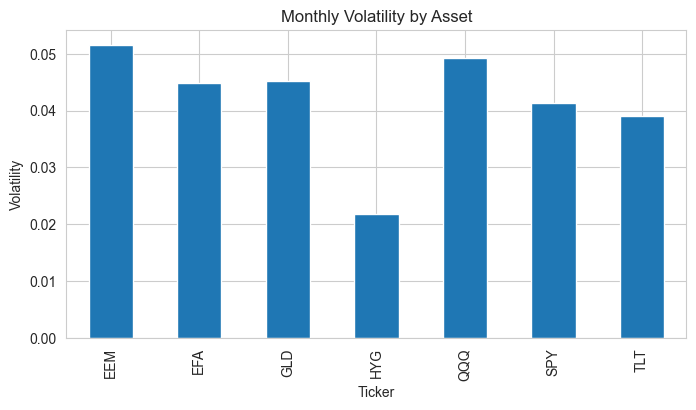

In [6]:
returns_m.std().plot(kind="bar", title="Monthly Volatility by Asset")
plt.ylabel("Volatility")
plt.show()

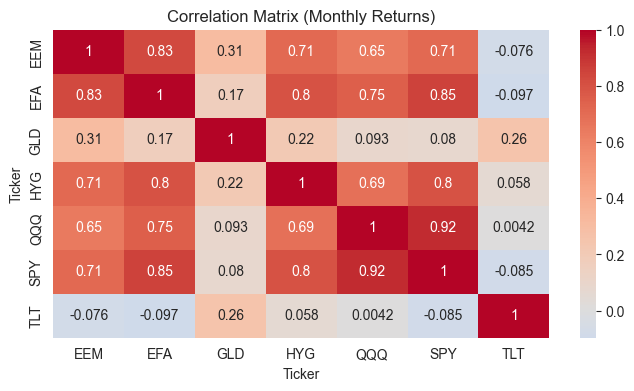

In [ ]:
sns.heatmap(
    returns_m.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix (Monthly Returns)")
plt.show()

- Volatility levels vary substantially across assets, reflecting heterogeneous risk profiles.
- Correlation patterns highlight clear diversification benefits, especially between equities, bonds, and gold.
- This risk heterogeneity naturally motivates risk-based or volatility-aware allocation strategies rather than return-driven optimization.

# 1. Simple Risk-Based Baselines

Before introducing advanced methods, we start with simple and robust baselines.

**Equal Weight (EW)**  
Each asset receives the same capital weight.

**Inverse Volatility (Inv-Vol)**  
Weights are inversely proportional to asset volatility:

$$
w_i \propto \frac{1}{\sigma_i}
$$

This reduces concentration in high-volatility assets.


In [8]:
n_assets = returns_m.shape[1]
assets = returns_m.columns

# Equal Weight
w_ew = np.ones(n_assets) / n_assets
w_ew = pd.Series(w_ew, index=assets)

# Inverse Volatility
vol = returns_m.std()
w_invvol = 1 / vol
w_invvol = w_invvol / w_invvol.sum()

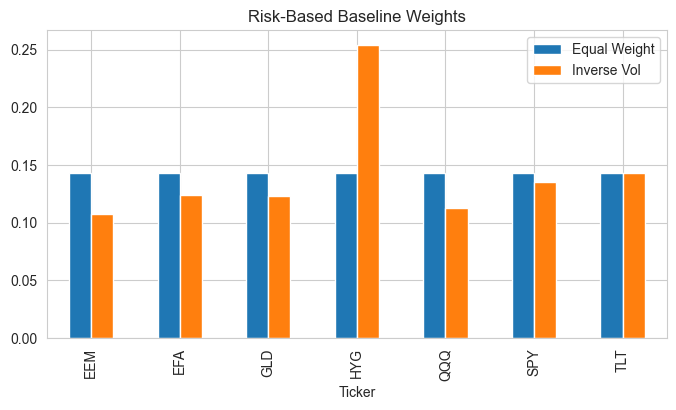

In [9]:
weights_df = pd.DataFrame({
    "Equal Weight": w_ew,
    "Inverse Vol": w_invvol
})

weights_df.plot(kind="bar", title="Risk-Based Baseline Weights")
plt.show()

**Risk contributions**

In [10]:
Sigma = returns_m.cov()

def risk_contribution(w, Sigma):
    w = np.array(w)
    port_var = w.T @ Sigma.values @ w
    mrc = Sigma.values @ w
    rc = w * mrc / np.sqrt(port_var)
    return pd.Series(rc, index=Sigma.columns)

rc_ew = risk_contribution(w_ew, Sigma)
rc_invvol = risk_contribution(w_invvol, Sigma)

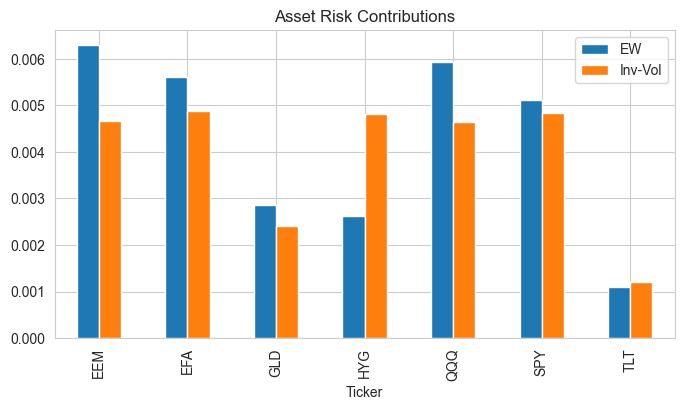

In [11]:
pd.DataFrame({
    "EW": rc_ew,
    "Inv-Vol": rc_invvol
}).plot(kind="bar", title="Asset Risk Contributions")
plt.show()

- Equal Weight assigns similar capital weights but ends up concentrating risk in the most volatile assets.
- Inverse Volatility reallocates capital toward lower-risk assets, leading to more balanced risk contributions.
- Even this simple risk-based adjustment delivers a substantial diversification improvement without any return forecasting.

# 2. Risk Parity / Equal Risk Contribution (ERC)

**Theory**

Portfolio volatility:
$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$

Marginal Risk Contribution:
$$
\mathrm{MRC}_i = \frac{(\Sigma w)_i}{\sigma_p}
$$

Total Risk Contribution:
$$
\mathrm{RC}_i = w_i \cdot \mathrm{MRC}_i
$$

Goal of ERC:
$$
\mathrm{RC}_i = \mathrm{RC}_j \quad \forall\, i,j
$$

The objective is to equalize sources of risk, not capital.


### Numerical implementation (scipy)

In [ ]:
def erc_objective(w, Sigma):
    w = np.array(w)
    port_var = w.T @ Sigma @ w
    mrc = Sigma @ w
    rc = w * mrc
    return np.sum((rc - port_var / len(w))**2)

constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}
)
bounds = [(0, 1) for _ in range(n_assets)]

w0 = np.ones(n_assets) / n_assets

res = minimize(
    erc_objective,
    w0,
    args=(Sigma.values,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_erc = pd.Series(res.x, index=assets)

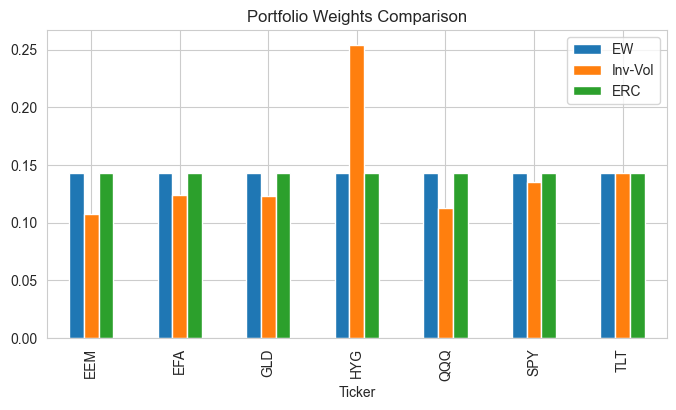

In [14]:
weights_df = pd.DataFrame({
    "EW": w_ew,
    "Inv-Vol": w_invvol,
    "ERC": w_erc
})

weights_df.plot(kind="bar", title="Portfolio Weights Comparison")
plt.show()

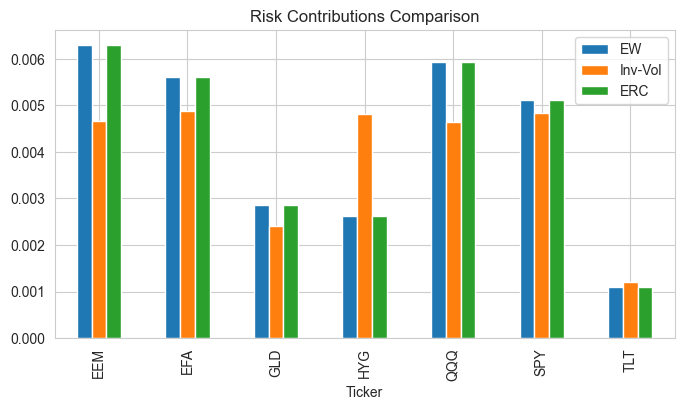

In [15]:
rc_erc = risk_contribution(w_erc, Sigma)

pd.DataFrame({
    "EW": rc_ew,
    "Inv-Vol": rc_invvol,
    "ERC": rc_erc
}).plot(kind="bar", title="Risk Contributions Comparison")
plt.show()

- ERC (Equal Risk Contribution) achieves a much more uniform distribution of risk across assets than Equal Weight or Inverse Volatility.
- Portfolio weights under ERC adapt to asset heterogeneity, producing balanced allocations despite large differences in volatility and correlation.
- This confirms that ERC directly targets risk balance rather than capital balance, making it a robust foundation for diversified portfolio construction.

# 3. Factor View: Light PCA Analysis

Asset-level diversification may still hide factor concentration. We use PCA as a simple way to uncover latent risk factors.

In [16]:
scaler = StandardScaler()
returns_std = scaler.fit_transform(returns_m)

pca = PCA(n_components=3)
pca.fit(returns_std)

explained_var = pca.explained_variance_ratio_

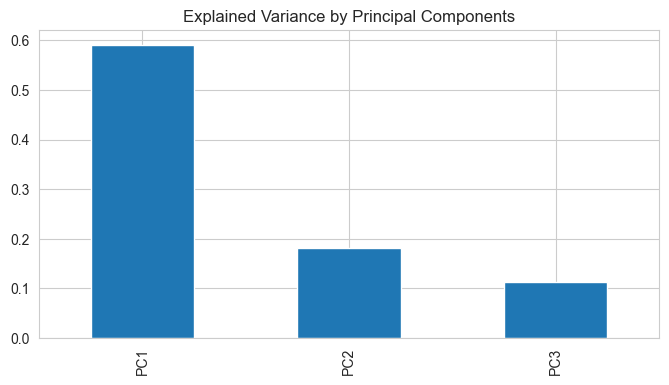

In [17]:
pd.Series(explained_var, index=["PC1", "PC2", "PC3"]).plot(
    kind="bar",
    title="Explained Variance by Principal Components"
)
plt.show()

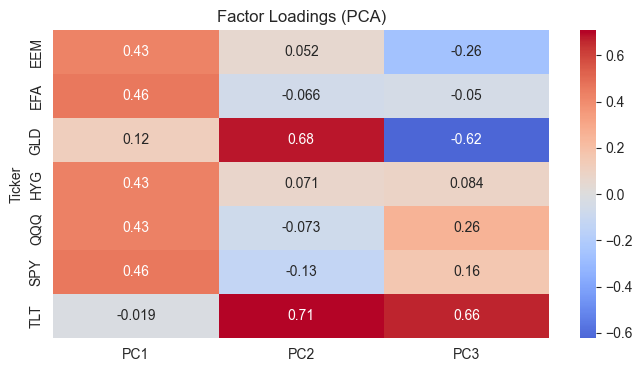

In [18]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=assets,
    columns=["PC1", "PC2", "PC3"]
)

sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Factor Loadings (PCA)")
plt.show()

- The first principal component (PC1) explains most of the variance and loads heavily on equity-like assets, capturing a global equity risk factor.
- PC2 and PC3 separate rates and defensive assets (bonds, gold), highlighting distinct macro risk dimensions.
- Despite holding multiple assets, portfolios remain exposed to a small number of dominant risk factors.
- This shows that asset diversification does not automatically imply factor diversification, reinforcing the need for factor-aware portfolio construction.

# 4. Factor Risk Contributions

We approximate factor risk contributions by projecting portfolio weights onto PCA loadings.


In [20]:
def factor_exposure(w, loadings):
    return loadings.T @ w

exp_erc = factor_exposure(w_erc, loadings)
exp_ew = factor_exposure(w_ew, loadings)

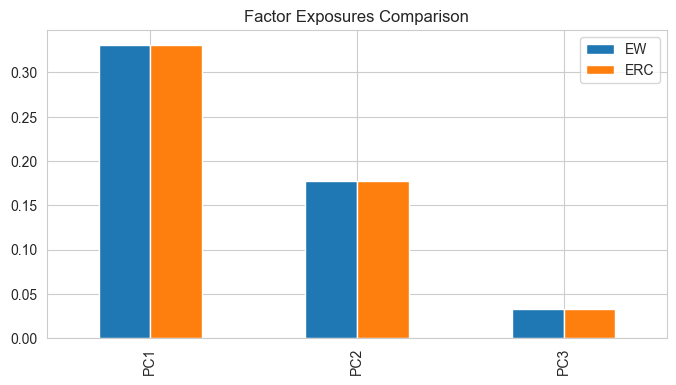

In [21]:
pd.DataFrame({
    "EW": exp_ew,
    "ERC": exp_erc
}).plot(kind="bar", title="Factor Exposures Comparison")
plt.show()

- Equal Weight portfolios inherit strong exposure to the dominant equity factor (PC1), leading to implicit factor concentration.
- Risk Parity / ERC slightly reduces this concentration by balancing risk across assets, which also smooths factor exposures.
- In contrast, Markowitz-style allocations tend to amplify dominant factor bets unintentionally through unstable weights.

# 5. Comparison with Markowitz

We compare portfolios in terms of weight concentration, risk contributions, and factor exposures.
The key insight is that Markowitz optimizes a fragile return–risk objective, leading to unstable allocations and implicit factor bets.

# Conclusion

Risk-based portfolios avoid unreliable return forecasts and produce more stable, economically interpretable allocations.

They deliberately sacrifice theoretical optimality, relying instead on risk structure and covariance estimates, which makes them more robust but still sensitive to regime changes.
In practice, this trade-off proves valuable: when expected returns are noisy, risk-based allocation offers a disciplined and realistic alternative to mean–variance optimization.